In [1]:
import os
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torch_geometric.data import Data
from scipy.spatial import Delaunay
from skimage.transform import resize
from torch_geometric.loader import DataLoader
from torch.nn import Linear, ReLU
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
import networkx as nx
from skimage.segmentation import slic, mark_boundaries
from skimage.measure import regionprops
from PIL import Image
import requests
import io

# Thiết lập style
sns.set(style='whitegrid')

In [2]:
# Đường dẫn dữ liệu
train_path = './data/seg_train/'
test_path = './data/seg_test/'
pred_path = './data/seg_pred/'

# Các lớp phân loại
code = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}

In [3]:
# Hàm chuyển mã số sang tên lớp
def get_name(code_number):
    for key, value in code.items():
        if code_number == value:
            return key

In [4]:
# 1. Hàm tạo đồ thị kết hợp SLIC + Delaunay
def create_combined_graph(image, n_segments=100, compactness=10):
    # Resize ảnh
    image = resize(image, (100, 100), anti_aliasing=True)
    
    # SLIC Segmentation
    segments = slic(image, n_segments=n_segments, compactness=compactness, sigma=1)
    regions = regionprops(segments + 1)
    
    # Tính features cho superpixels
    centers = np.array([r.centroid for r in regions])  # Vị trí trung tâm
    colors = np.array([image[segments == i].mean(axis=0) for i in np.unique(segments)])  # Màu trung bình
    
    # Delaunay Triangulation
    tri = Delaunay(centers)
    edges = set()
    for simplex in tri.simplices:
        for i in range(3):
            edge = tuple(sorted((simplex[i], simplex[(i + 1) % 3])))
            edges.add(edge)
    edges = np.array(list(edges)).T
    
    # Tạo đồ thị PyTorch Geometric
    x = torch.tensor(np.hstack([colors, centers]), dtype=torch.float)  # Features: màu (3) + vị trí (2)
    edge_index = torch.tensor(edges, dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index), segments


In [ ]:
def load_and_process_data(path, folder_name, new_size=100):
    X, y = [], []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname=path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = cv2.imread(file)[..., ::-1]  # BGR to RGB
                image = cv2.resize(image, (new_size, new_size))
                X.append(image)
                y.append(code[folder])
    else:
        files = gb.glob(pathname=path + folder_name + '/*.jpg')
        for file in files:
            image = cv2.imread(file)[..., ::-1]
            image = cv2.resize(image, (new_size, new_size))
            X.append(image)
    return np.array(X), np.array(y) if folder_name != 'seg_pred' else np.array(X)

In [ ]:
def convert_to_graphs(X, y=None):
    graphs = []
    for i, image in enumerate(X):
        graph, _ = create_combined_graph(image)
        if y is not None:
            graph.y = torch.tensor(y[i], dtype=torch.long)
        graphs.append(graph)
    return graphs

class CombinedGCN(torch.nn.Module):
    def __init__(self, input_dim=5, hidden_dims=[256, 128, 64], num_classes=6):
        super(CombinedGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.bn1 = BatchNorm(hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.bn2 = BatchNorm(hidden_dims[2])
        self.fc = Linear(hidden_dims[2], num_classes)
        self.relu = ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.bn1(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.bn2(x)
        x = global_mean_pool(x, batch)
        return self.fc(x)

In [ ]:
def visualize_graph(image, graph):
    plt.figure(figsize=(15, 6))
    
    # Ảnh gốc với superpixel boundaries
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Đồ thị
    plt.subplot(1, 2, 2)
    G = nx.Graph()
    node_features = graph.x.numpy()
    for i in range(graph.num_nodes):
        G.add_node(i, pos=node_features[i, 3:], color=node_features[i, :3])
    
    for edge in graph.edge_index.t().numpy():
        G.add_edge(edge[0], edge[1])
    
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = [G.nodes[i]['color'] for i in G.nodes]
    nx.draw(G, pos, node_size=30, node_color=node_colors, width=0.5)
    plt.title("Graph Representation")
    plt.show()


In [ ]:
print("Loading data...")
X_train, y_train = load_and_process_data(train_path, 'seg_train')
X_test, y_test = load_and_process_data(test_path, 'seg_test')
X_pred, _ = load_and_process_data(pred_path, 'seg_pred')

Loading data...


In [ ]:
print("Creating graphs...")
train_graphs = convert_to_graphs(X_train, y_train)
test_graphs = convert_to_graphs(X_test, y_test)

Creating graphs...


In [ ]:
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedGCN(input_dim=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    correct = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(test_graphs)

print("Training model...")
for epoch in range(1, 16):
    train_loss = train()
    val_acc = validate()
    print(f'Epoch {epoch}, Loss: {train_loss:.4f}, Accuracy: {val_acc:.4f}')

Training model...
Epoch 1, Loss: 1.4864, Accuracy: 0.1600
Epoch 2, Loss: 1.3662, Accuracy: 0.4000
Epoch 3, Loss: 1.3277, Accuracy: 0.4683
Epoch 4, Loss: 1.2898, Accuracy: 0.4210
Epoch 5, Loss: 1.2616, Accuracy: 0.3437
Epoch 6, Loss: 1.2369, Accuracy: 0.3663
Epoch 7, Loss: 1.2128, Accuracy: 0.4560
Epoch 8, Loss: 1.1987, Accuracy: 0.3850
Epoch 9, Loss: 1.1886, Accuracy: 0.4083
Epoch 10, Loss: 1.1661, Accuracy: 0.2877
Epoch 11, Loss: 1.1566, Accuracy: 0.4940
Epoch 12, Loss: 1.1465, Accuracy: 0.3757
Epoch 13, Loss: 1.1373, Accuracy: 0.3010
Epoch 14, Loss: 1.1259, Accuracy: 0.3650
Epoch 15, Loss: 1.1228, Accuracy: 0.5263


In [ ]:
def evaluate():
    model.eval()
    y_true, y_pred = [], []
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(out.argmax(dim=1).cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate()

Visualizing results...


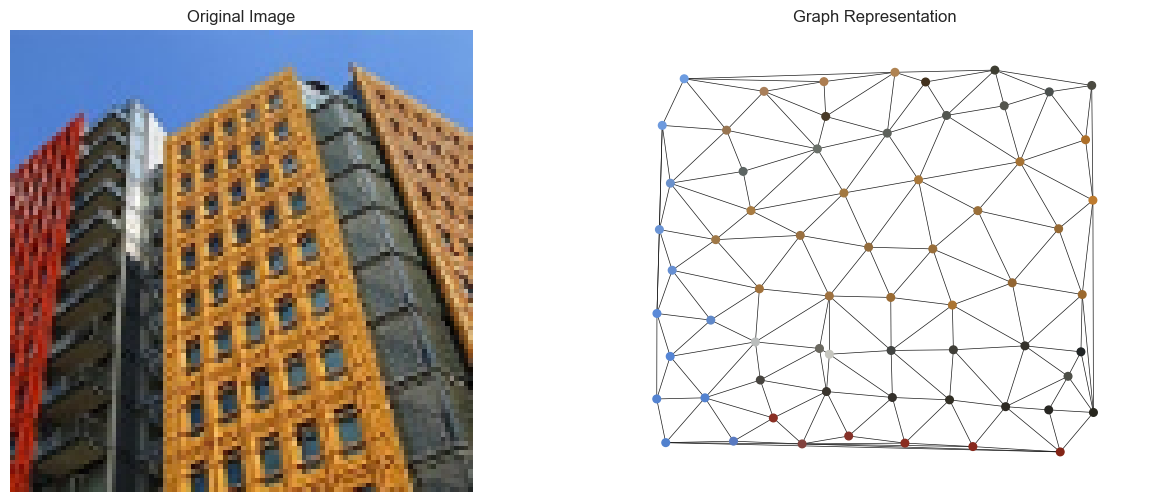

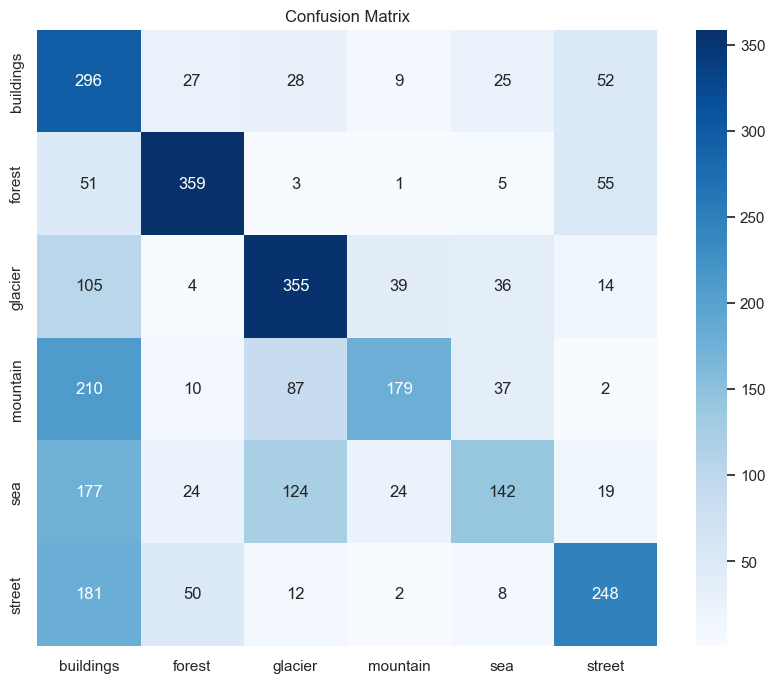

In [ ]:
print("Visualizing results...")
sample_idx = 42
sample_image = X_train[sample_idx]
sample_graph = train_graphs[sample_idx]
visualize_graph(sample_image, sample_graph)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=code.keys(), 
            yticklabels=code.keys())
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_from_url(url):
    try:
        response = requests.get(url)
        img = Image.open(io.BytesIO(response.content)).convert('RGB')
        img = np.array(img)[..., ::-1]  # RGB to BGR
        img = cv2.resize(img, (100, 100))
        
        # Tạo đồ thị
        graph, segments = create_combined_graph(img)
        graph = graph.to(device)
        
        # Dự đoán
        with torch.no_grad():
            out = model(graph)
            pred = out.argmax(dim=1).item()
        
        # Visualize
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(img[..., ::-1])  # BGR to RGB
        plt.title(f"Predicted: {get_name(pred)}")
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mark_boundaries(img[..., ::-1], segments))
        plt.title("SLIC Segmentation")
        plt.axis('off')
        
        plt.subplot(1,3,3)
        G = nx.Graph()
        features = graph.x.cpu().numpy()
        for i in range(graph.num_nodes):
            G.add_node(i, pos=features[i,3:], color=features[i,:3])
        for edge in graph.edge_index.t().cpu().numpy():
            G.add_edge(edge[0], edge[1])
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw(G, pos, node_size=20, node_color=[G.nodes[i]['color'] for i in G.nodes], width=0.5)
        plt.title("Graph Representation")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")

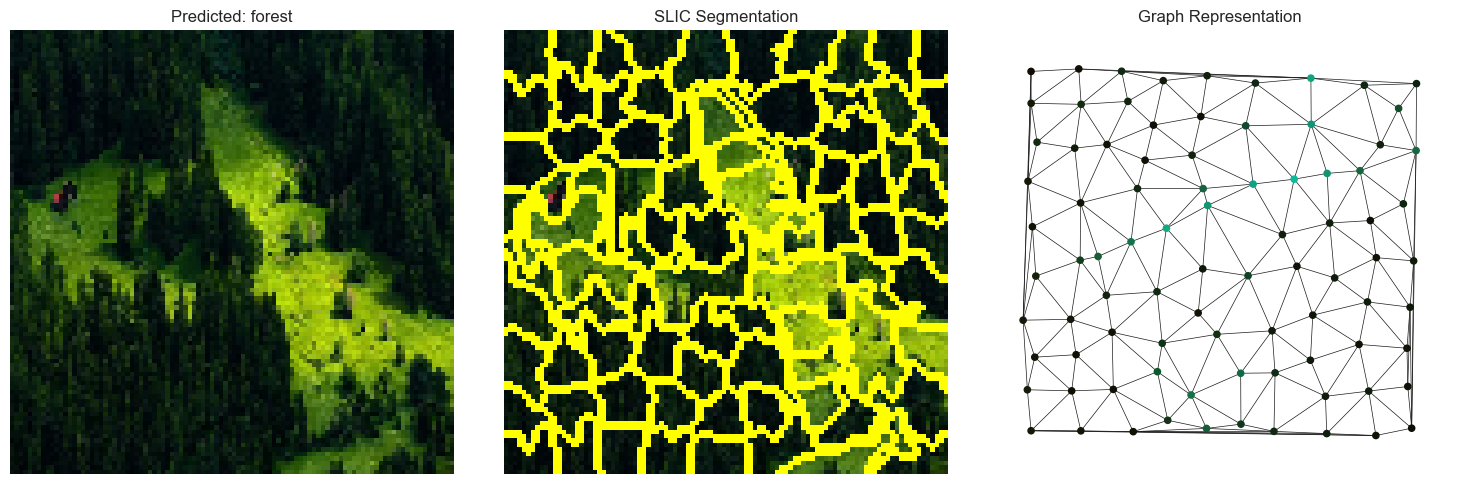

In [ ]:
predict_from_url('https://anhdep.edu.vn/upload/2024/10/cap-nhat-50-hinh-anh-phong-canh-khu-rung-la-kim-day-tho-mong-2.webp')

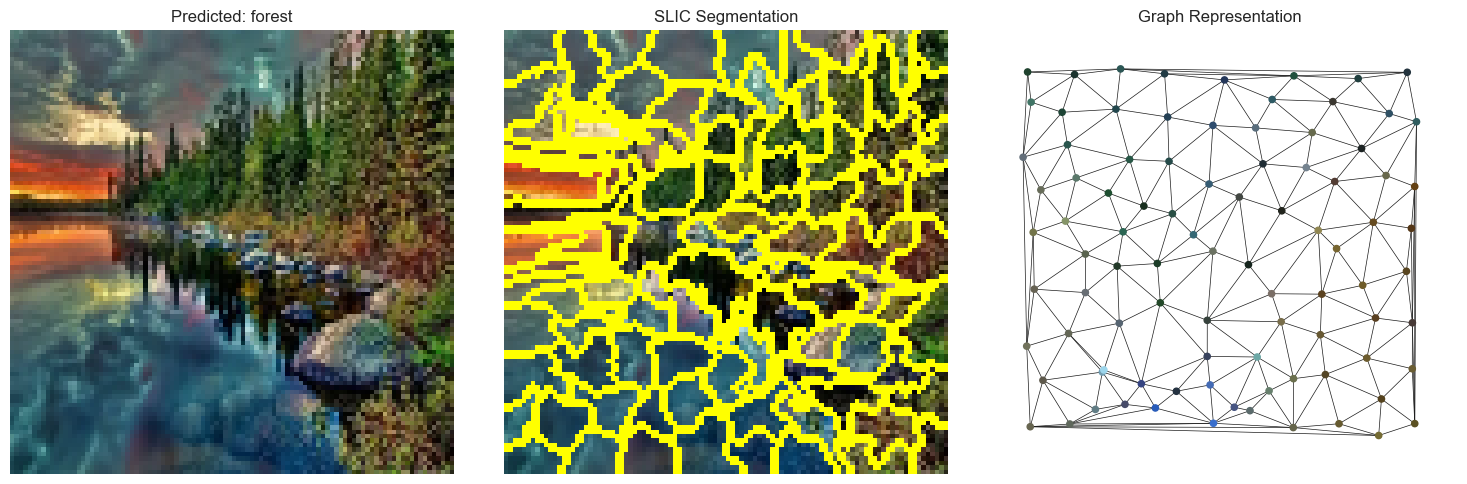

In [21]:
predict_from_url('https://anhdep.edu.vn/upload/2024/05/bo-suu-tap-anh-phong-canh-nui-rung-hung-vi-va-an-tuong-0.webp')

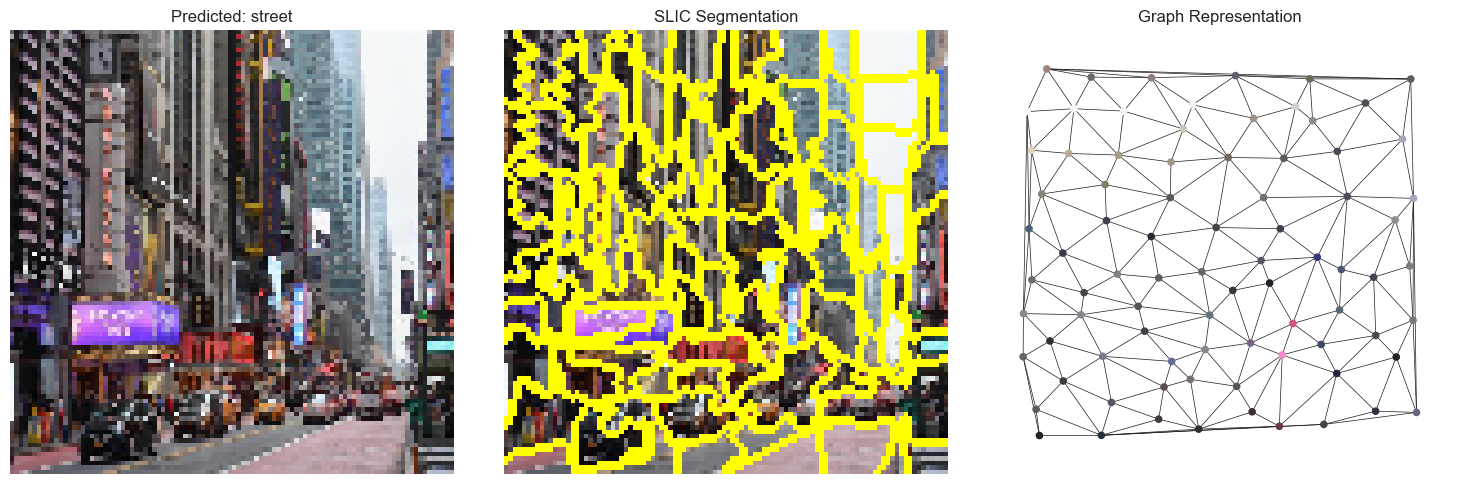

In [24]:
predict_from_url('https://cdnmedia.baotintuc.vn/Upload/3qVxwVtNEPp6Wp9kkF77g/files/2020/06/20/new-york-200620.jpg')

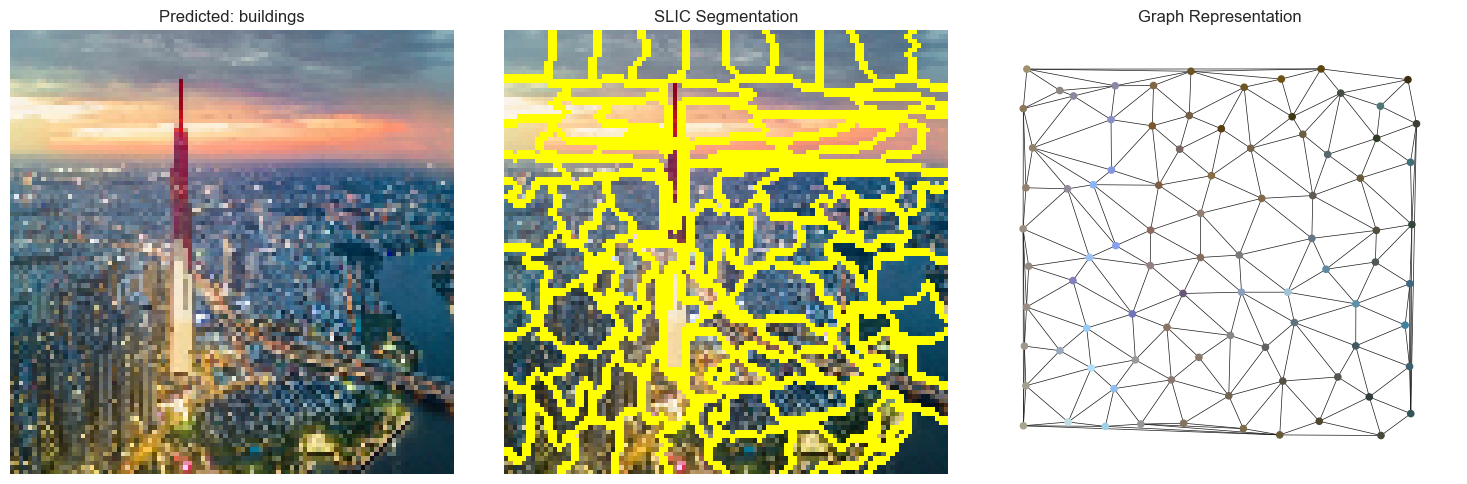

In [25]:
predict_from_url('https://vanphongchothue.vn/uploads/noidung/images/toa-thap-view-dep-nhat-thanh-pho-ho-chi-minh.jpg')